In [1]:
import os
import numpy as np  
import pandas as pd
import seaborn as sns

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise import KNNWithZScore
from surprise import SVD
from surprise import Reader
from surprise import SVDpp


In [2]:
#Set the working directory
os.chdir('F:/Nag/Olympus/Recommendation System/Project')

In [3]:
#Read CSV file and add column names
ratings_data = pd.read_csv("ratings_electronics.csv")  
ratings_data.columns = ['userId','productId','rating','timestamp']


ratings_data.head() 

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
ratings_data.size

31297924

In [5]:
ratings_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [6]:
ratings_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [7]:
#Check for invalid or null data.
print(ratings_data.isnull().sum())

userId       0
productId    0
rating       0
timestamp    0
dtype: int64


In [8]:
print('Number of unique Products: ' , ratings_data['productId'].nunique())
print('Number of unique Users: ', ratings_data['userId'].nunique())

Number of unique Products:  476001
Number of unique Users:  4201696


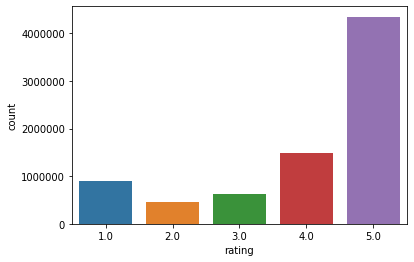

In [9]:
#plot different ratings from data
sns.countplot('rating', data = ratings_data)

In [10]:
#Filter for users data who rated at least 50 products
ratings_counts = ratings_data['userId'].value_counts()
ratings_filtered = (ratings_data[ratings_data['userId'].isin(ratings_counts[ratings_counts >= 50].index)])

#Get dataframe for train and test sets
df = pd.DataFrame(ratings_filtered)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'productId', 'rating']], reader)


In [11]:
#split train and test sets
trainset, testset = train_test_split(data, test_size=.30, random_state=3)

In [12]:
#Get 5 most popular recommendations
popularity_recommendations = ratings_filtered.groupby('productId')['rating'].mean().sort_values(ascending=False).head()
print(popularity_recommendations)

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: rating, dtype: float64


In [13]:
def get_popular(userId):
    user_recommendations = pd.DataFrame(popularity_recommendations)
    user_recommendations['userId'] = userId
    return user_recommendations

In [14]:
#Get sample users list
userIds = df.head()['userId']

In [15]:
#Get popularity based recommendations for the sample users.
for user in userIds:
    print(get_popular(user))
    print("\n")
   

            rating          userId
productId                         
B00LKG1MC8     5.0  A3BY5KCNQZXV5U
B002QUZM3M     5.0  A3BY5KCNQZXV5U
B002QWNZHU     5.0  A3BY5KCNQZXV5U
B002QXZPFE     5.0  A3BY5KCNQZXV5U
B002R0DWNS     5.0  A3BY5KCNQZXV5U


            rating         userId
productId                        
B00LKG1MC8     5.0  AT09WGFUM934H
B002QUZM3M     5.0  AT09WGFUM934H
B002QWNZHU     5.0  AT09WGFUM934H
B002QXZPFE     5.0  AT09WGFUM934H
B002R0DWNS     5.0  AT09WGFUM934H


            rating          userId
productId                         
B00LKG1MC8     5.0  A32HSNCNPRUMTR
B002QUZM3M     5.0  A32HSNCNPRUMTR
B002QWNZHU     5.0  A32HSNCNPRUMTR
B002QXZPFE     5.0  A32HSNCNPRUMTR
B002R0DWNS     5.0  A32HSNCNPRUMTR


            rating          userId
productId                         
B00LKG1MC8     5.0  A17HMM1M7T9PJ1
B002QUZM3M     5.0  A17HMM1M7T9PJ1
B002QWNZHU     5.0  A17HMM1M7T9PJ1
B002QXZPFE     5.0  A17HMM1M7T9PJ1
B002R0DWNS     5.0  A17HMM1M7T9PJ1


            rating 

In [16]:
from surprise import AlgoBase
from collections import defaultdict

In [17]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
        
        

In [18]:
# for collaborative filtering model

In [19]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering

algo = KNNWithMeans(k=200, sim_options={'name': 'pearson_baseline',  'user_based': True })
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [20]:
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=True)

RMSE: 1.0592


1.059166583233721

In [21]:
top_n = get_top_n(predictions, n=5)

print(top_n)



defaultdict(<class 'list'>, {'A1HBEQWSMVQEWJ': [('B007GO2OPW', 4.26083600994223), ('B00DWGB6CU', 4.26083600994223), ('B004P65UC8', 4.26083600994223), ('B006WLBEPQ', 4.26083600994223), ('B009UDTUNG', 4.26083600994223)], 'A3R1WFO4KIUQXZ': [('B002VJKAW6', 5), ('B0058UUR6E', 4.947462954647508), ('B009GYIKHQ', 4.903743315508022), ('B00829TIEK', 4.811340381046828), ('B001MSU1FS', 4.805488979504076)], 'A2CL818RN52NWN': [('B0000514G8', 4.425925925925926), ('B000J13TEE', 4.425925925925926), ('B000MTRWVY', 4.26083600994223), ('B00018WNS8', 4.26083600994223), ('B0007P4G6M', 4.26083600994223)], 'A19X4BF861LQST': [('B001R4BBL0', 4.26083600994223), ('B0009S7YJS', 4.26083600994223), ('B0011FQUUW', 4.26083600994223), ('B0022ISVG8', 4.26083600994223), ('B002PJ40Q4', 4.26083600994223)], 'A39K52QDP4C3ZS': [('B000Z80ICM', 4.444444444444445), ('B00342UT84', 4.444444444444445), ('B000FBK3QK', 4.444444444444445), ('B008J26ZL4', 4.444444444444445), ('B009IM6RWQ', 4.444444444444445)], 'AT28RL25Q2OLK': [('B00GN

In [22]:
algo_zscore = KNNWithZScore(k=500, sim_options={'name': 'cosine', 'shrinkage': 0})
algo_zscore.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [23]:
predictions_zscore = algo_zscore.test(testset)
accuracy.rmse(predictions_zscore, verbose=True)

RMSE: 1.0639


1.0638911273388254

In [24]:
#Try SVD - for collaborative filtering algorithms
svd_algo = SVD()
svd_algo.fit(trainset)

In [25]:
predictions_svd = svd_algo.test(testset)
accuracy.rmse(predictions_svd, verbose=True)

RMSE: 0.9872


0.9871956811388926

In [26]:
top_n_svd = get_top_n(predictions_svd, n=5)
print(top_n_svd)

defaultdict(<class 'list'>, {'A1HBEQWSMVQEWJ': [('B000QUUFRW', 4.55112280811247), ('B0019M6GP6', 4.318347053602008), ('B005CT56F8', 4.314985865597318), ('B00A0ABQLM', 4.28104490747103), ('B005IHAI8O', 4.0846039125392615)], 'A3R1WFO4KIUQXZ': [('B00829TIEK', 4.558055133906267), ('B004LNXO28', 4.4682996457692745), ('B001MSU1FS', 4.459502077177535), ('B00829TIA4', 4.429619712541434), ('B004ZP74IM', 4.379957955591716)], 'A2CL818RN52NWN': [('B000MTRWVY', 4.42181692526607), ('B00018WNS8', 4.42181692526607), ('B0007P4G6M', 4.42181692526607), ('B0007PN5ZK', 4.42181692526607), ('B0009RMGTC', 4.42181692526607)], 'A19X4BF861LQST': [('B000BQ7GW8', 4.312525477136739), ('B0013FRNKG', 4.1609991348512585), ('B0014LA4NM', 4.014849075740406), ('B004FPYJFI', 4.006398071594225), ('B00004ZCA5', 3.939782373840009)], 'A39K52QDP4C3ZS': [('B00484IEJS', 4.763715208860945), ('B004RORMF6', 4.751459915544863), ('B002IXZ5DE', 4.584635353337762), ('B002Z2QDNE', 4.581894931021357), ('B007YXA5TC', 4.5735554496506365)],

In [27]:
#Try SVDPP - for collaborative filtering algorithms
svdpp_algo = SVDpp()
svdpp_algo.fit(trainset)

In [28]:
predictions_svdpp = svd_algo.test(testset)
accuracy.rmse(predictions_svdpp, verbose=True)


RMSE: 0.9872


0.9871956811388926

In [29]:
top_n_svdpp = get_top_n(predictions_svdpp, n=5)
print(top_n_svdpp)

defaultdict(<class 'list'>, {'A1HBEQWSMVQEWJ': [('B000QUUFRW', 4.55112280811247), ('B0019M6GP6', 4.318347053602008), ('B005CT56F8', 4.314985865597318), ('B00A0ABQLM', 4.28104490747103), ('B005IHAI8O', 4.0846039125392615)], 'A3R1WFO4KIUQXZ': [('B00829TIEK', 4.558055133906267), ('B004LNXO28', 4.4682996457692745), ('B001MSU1FS', 4.459502077177535), ('B00829TIA4', 4.429619712541434), ('B004ZP74IM', 4.379957955591716)], 'A2CL818RN52NWN': [('B000MTRWVY', 4.42181692526607), ('B00018WNS8', 4.42181692526607), ('B0007P4G6M', 4.42181692526607), ('B0007PN5ZK', 4.42181692526607), ('B0009RMGTC', 4.42181692526607)], 'A19X4BF861LQST': [('B000BQ7GW8', 4.312525477136739), ('B0013FRNKG', 4.1609991348512585), ('B0014LA4NM', 4.014849075740406), ('B004FPYJFI', 4.006398071594225), ('B00004ZCA5', 3.939782373840009)], 'A39K52QDP4C3ZS': [('B00484IEJS', 4.763715208860945), ('B004RORMF6', 4.751459915544863), ('B002IXZ5DE', 4.584635353337762), ('B002Z2QDNE', 4.581894931021357), ('B007YXA5TC', 4.5735554496506365)],